# Define Train and Validate the models

This notebook uses the csv from the data dir as input and builds, trains and predicts a model using keras.

It uses standardized data.

In [85]:
import datetime
#from pathlib import Path
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import os.path


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [86]:
print(tf.__version__)

2.14.0


In [87]:
# The current directory will be where this src file is located.
# Which is in the src dir of the project
dirpath = os.getcwd()
print("current directory is : " + dirpath)

current directory is : /Users/davis/progs/github/Keras-Philosophy/notebooks


In [88]:
# Use pathlib to find the root dir of the git repo
root_path = pathlib.PurePath(dirpath).parents[0]
data_path = root_path / 'data'
logs_path = root_path / 'logs'
print("root directory is: ", root_path)
print("data directory is: ",  data_path)
print("logs directory is: ", logs_path)


root directory is:  /Users/davis/progs/github/Keras-Philosophy
data directory is:  /Users/davis/progs/github/Keras-Philosophy/data
logs directory is:  /Users/davis/progs/github/Keras-Philosophy/logs


In [89]:
# Create equivalent dir names in the environment
# Logs
LOGS_DIR_NAME = logs_path.as_posix()
print("LOGS_DIR_NAME: ", LOGS_DIR_NAME)
os.environ['LOGS_DIR_NAME'] = LOGS_DIR_NAME
# Data
DATA_DIR_NAME = data_path.as_posix()
print("DATA_DIR_NAME: ", DATA_DIR_NAME)
os.environ['DATA_DIR_NAME'] = DATA_DIR_NAME

LOGS_DIR_NAME:  /Users/davis/progs/github/Keras-Philosophy/logs
DATA_DIR_NAME:  /Users/davis/progs/github/Keras-Philosophy/data


In [90]:
%%bash
# Verify env variables are set
echo ${DATA_DIR_NAME}
echo ${LOGS_DIR_NAME}

/Users/davis/progs/github/Keras-Philosophy/data
/Users/davis/progs/github/Keras-Philosophy/logs


In [91]:
%%bash
echo "LOG_DIR_NAME: ${LOG_DIR_NAME}"

LOG_DIR_NAME: 


In [92]:
train_csv = data_path /  pathlib.PurePath("train.csv")
test_csv = data_path /  pathlib.PurePath("test.csv")
valid_csv = data_path /  pathlib.PurePath("valid.csv")
train_stats_csv = data_path /  pathlib.PurePath("train_stats.csv")

# Read the dataframes using pandas

In [93]:
# Read the csv files into dataframes
train_df = pd.read_csv(train_csv, 
                          header=0,
                          sep=",")
valid_df = pd.read_csv(valid_csv, 
                          header=0,
                          sep=",")
test_df = pd.read_csv(test_csv, 
                          header=0,
                          sep=",")
train_stats_df = pd.read_csv(train_stats_csv, 
                          header=0,
                          sep=",")
train_stats_df.index=['z','x','y']


In [94]:
# Create vectors of the training labels
# assumes Y label is called z
# 
train_labels = train_df.pop('z')
test_labels = test_df.pop('z')
valid_labels = valid_df.pop('z')

In [95]:
train_labels

0      0.399859
1      0.063977
2      0.735740
3      0.063977
4      0.399859
         ...   
247   -1.951310
248    0.735740
249    0.399859
250   -2.623073
251    0.399859
Name: z, Length: 252, dtype: float64

In [96]:
train_df.keys()

Index(['x', 'y'], dtype='object')

In [97]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(252, 2)
(54, 2)
(54, 2)


# plot the data

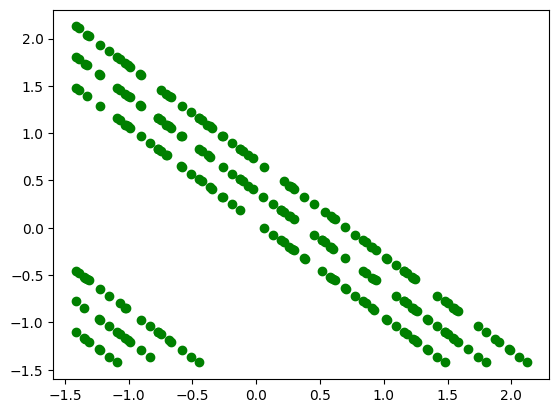

In [98]:
plt.scatter(train_df['y'], train_df['x'], c='green')

# Build the model

In [119]:

# Build a 3 layer 64, 16, 4 node DNN
model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_df.keys())]),
    layers.Dense(16, activation=tf.nn.relu),
    layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
    ])

# Build a 2 layer 64, 64 node DNN
#model = keras.Sequential([
#    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_df.keys())]),
#    layers.Dense(64, activation=tf.nn.relu),
#    layers.Dense(1)
#    ])



# Build a 2 layer 16, 4 node DNN
#model = keras.Sequential([
#    layers.Dense(16, activation=tf.nn.relu, input_shape=[len(train_df.keys())]),
#    layers.Dense(4, activation=tf.nn.relu),
#    layers.Dense(1)
#    ])




# Create a 1 layer 12 node DNN
#model = keras.Sequential([
#    layers.Dense(12, activation=tf.nn.relu, input_shape=[len(train_df.keys())]),
#    layers.Dense(1)
#    ])



# orig
optimizer = tf.keras.optimizers.RMSprop(0.001)
# increase learning rate if fairly consistent but slow changing
#optimizer = tf.keras.optimizers.RMSprop(0.01)
# 0.1 is too big
#optimizer = tf.keras.optimizers.RMSprop(0.1)
# with the early stop, lets try to make the learning rate smaller
#optimizer = tf.keras.optimizers.RMSprop(0.0001)

# Add in the early stop code
# The patience parameter is the amount of epochs to check for improvement
#
# NOTE: This was a good addition.  I'm so used to running through a lot of steps
# I did not realize that it was finding its best results so early.  In the 
# graphs that follows, you can see the divergent graphs here where the others
# did not show it since it was hundreds of epochs past optimal.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)



model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])


# Train the model (with three callbacks)

In [120]:
EPOCHS = 1000

In [121]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [122]:
#                    batch_size=16,

history = model.fit(train_df, 
                    train_labels,
                    epochs=EPOCHS,
                    validation_data = (valid_df, valid_labels),
                    verbose=1,
                    callbacks=[early_stop, PrintDot()])

Epoch 1/1000
8/8 [==============================] - 1s 39ms/step - loss: 2.1257 - mean_absolute_error: 1.1449 - mean_squared_error: 2.1257 - val_loss: 1.6612 - val_mean_absolute_error: 0.9917 - val_mean_squared_error: 1.6612
Epoch 2/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.5642 - mean_absolute_error: 0.9405 - mean_squared_error: 1.5642 - val_loss: 1.3709 - val_mean_absolute_error: 0.8679 - val_mean_squared_error: 1.3709
Epoch 3/1000
8/8 [==============================] - 0s 12ms/step - loss: 1.3585 - mean_absolute_error: 0.8522 - mean_squared_error: 1.3585 - val_loss: 1.2101 - val_mean_absolute_error: 0.7925 - val_mean_squared_error: 1.2101
Epoch 4/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.2070 - mean_absolute_error: 0.7815 - mean_squared_error: 1.2070 - val_loss: 1.0527 - val_mean_absolute_error: 0.7192 - val_mean_squared_error: 1.0527
Epoch 5/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.0652 - mean_absolute_erro

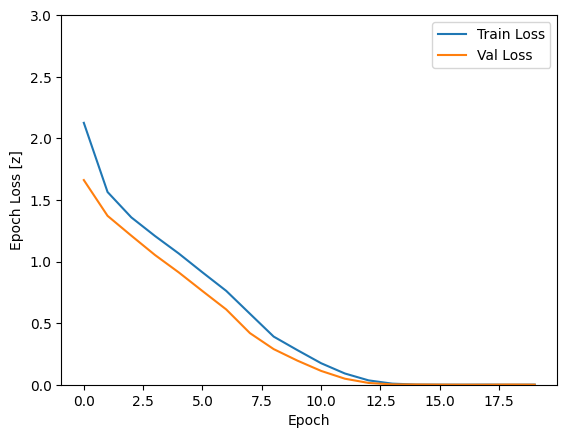

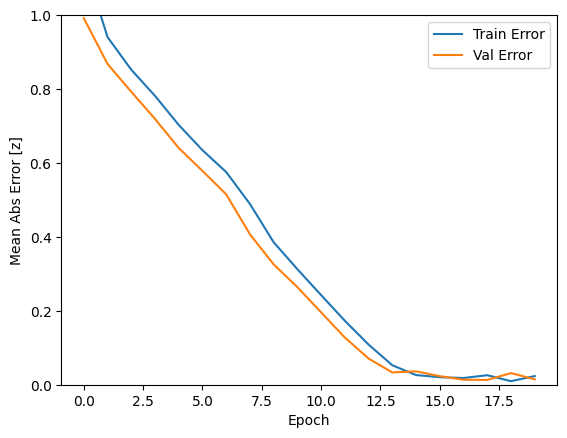

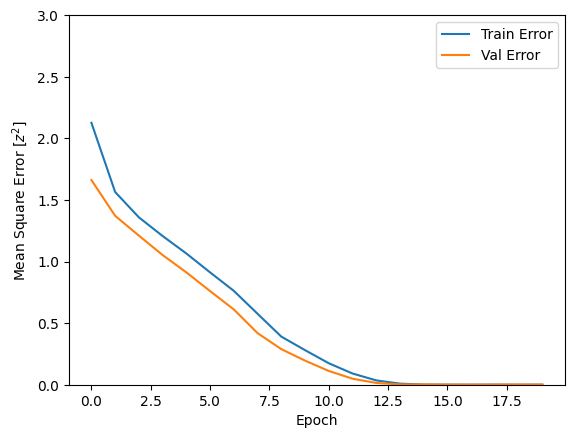

In [123]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch


    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Epoch Loss [z]')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.ylim([0,3])
    plt.legend()


    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [z]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$z^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

In [124]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [125]:
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,2.125739,1.144902,2.125739,1.661185,0.991672,1.661185,0
1,1.564151,0.940523,1.564151,1.370861,0.867878,1.370861,1
2,1.358498,0.852198,1.358498,1.210053,0.792538,1.210053,2
3,1.207038,0.781504,1.207038,1.052701,0.719178,1.052701,3
4,1.065243,0.702813,1.065243,0.911747,0.640496,0.911747,4
5,0.911823,0.634495,0.911823,0.760258,0.578426,0.760258,5
6,0.761849,0.575391,0.761849,0.611090,0.515013,0.611090,6
7,0.575966,0.489048,0.575966,0.418784,0.406971,0.418784,7
8,0.390585,0.385367,0.390585,0.289057,0.325582,0.289057,8
9,0.280664,0.312521,0.280664,0.195566,0.263847,0.195566,9


Now we are getting reasonable results.  Using a smaller learning rate, with an early stop callback.

# Evauate model
Note by including the data with missing values and adding in average amounts increased the error.

In [126]:
loss, mae, mse = model.evaluate(test_df, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} predicted xxt".format(mae))

Testing set Mean Abs Error:  0.01 predicted xxt


# Make predictions

2/2 [==============================] - 0s 8ms/step


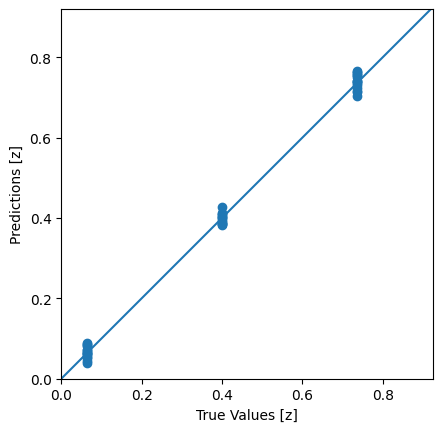

In [127]:
test_predictions = model.predict(test_df).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [z]')
plt.ylabel('Predictions [z]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Look at error distribution

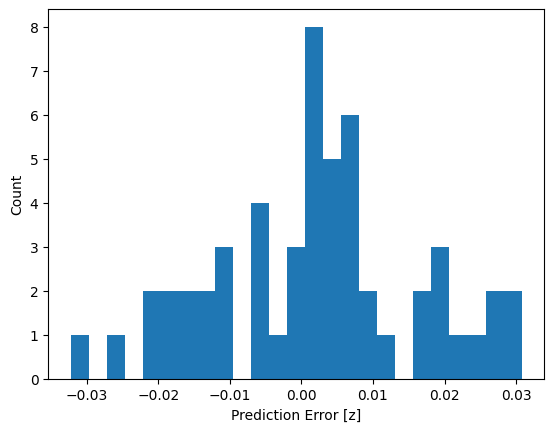

In [128]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [z]")
_ = plt.ylabel("Count")

In [129]:
test_df


,x,y
0,0.765732,-0.057999
1,0.320914,0.063268
2,-0.879961,-1.312988
3,-1.168957,1.867435
4,-0.845989,0.903165
5,0.513272,0.193254
6,0.975314,-0.909424
7,0.734881,-0.348718
8,1.737758,-1.346797
9,-0.476785,0.535728


In [130]:
model.predict(test_df)

2/2 [==============================] - 0s 5ms/step


array([[ 0.7412471 ],
       [ 0.40031993],
       [-2.2810996 ],
       [ 0.70350224],
       [ 0.04530545],
       [ 0.73632175],
       [ 0.08083824],
       [ 0.4083963 ],
       [ 0.42796203],
       [ 0.05250848],
       [ 0.3941841 ],
       [ 0.0844259 ],
       [ 0.05409644],
       [ 0.05922212],
       [ 0.7300207 ],
       [ 0.40269727],
       [ 0.75163686],
       [-2.2808185 ],
       [-2.2854228 ],
       [ 0.7409261 ],
       [-1.9504606 ],
       [ 0.3894933 ],
       [ 0.38771796],
       [-2.2867982 ],
       [ 0.72202307],
       [ 0.7642389 ],
       [ 0.713666  ],
       [ 0.38385504],
       [ 0.07050934],
       [ 0.38141692],
       [-1.9468575 ],
       [ 0.41154927],
       [ 0.73903495],
       [ 0.7564002 ],
       [ 0.08941219],
       [-2.2917087 ],
       [ 0.75524   ],
       [ 0.766512  ],
       [ 0.06382637],
       [ 0.3851697 ],
       [-1.9468731 ],
       [ 0.07044844],
       [ 0.4090591 ],
       [ 0.71544105],
       [-1.94885   ],
       [-2

## Manual prediction

In [131]:
# cherry pick some tests

# 10 = 6.0 + 4.0 
adf1 = pd.DataFrame([[6.0, 4.0]], columns=['x','y'])


# 7 = 2.37 + 4.63 <------- NOTICE: not in xyz10 dataset
adf2 = pd.DataFrame([[2.37, 4.63]], columns=['x','y'])

# 127.019 = 35.789 + 91.23 <---- NOTICE: way outside our bounds for training data
adf3 = pd.DataFrame([[35.789, 91.23]], columns=['x','y'])


print("data frame 1 for sum=10")
print(adf1)
# predict
print("prediction, sum should be 10")
print(model.predict(adf1))
print("*********")


print("data frame 2 for sum=7")
print(adf2)
# predict
print("prediction, sum should be 7")
print(model.predict(adf2))
print("*********")

print("data frame 3 for sum=127.019")
print(adf3)
# predict
print("prediction, sum should be 127.019")
print(model.predict(adf3))
print("*********")


data frame 1 for sum=10
     x    y
0  6.0  4.0
prediction, sum should be 10
1/1 [==============================] - 0s 28ms/step
[[10.422714]]
*********
data frame 2 for sum=7
      x     y
0  2.37  4.63
prediction, sum should be 7
1/1 [==============================] - 0s 12ms/step
[[7.268806]]
*********
data frame 3 for sum=127.019
        x      y
0  35.789  91.23
prediction, sum should be 127.019
1/1 [==============================] - 0s 14ms/step
[[131.8168]]
*********
